In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import pickle

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 224

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(12345);

In [3]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        
    return predictions

In [4]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

use_gpu = torch.cuda.is_available()

labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

batch_size = 12
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

criterion = nn.CrossEntropyLoss()

In [5]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/16
----------
train Loss: 2.4720 Acc: 0.1935
val Loss: 2.2683 Acc: 0.2061
lr:  0.01

Epoch 1/16
----------
train Loss: 2.1276 Acc: 0.2743
val Loss: 2.0974 Acc: 0.2668
lr:  0.01

Epoch 2/16
----------
train Loss: 2.0472 Acc: 0.2954
val Loss: 2.0585 Acc: 0.3128
lr:  0.01

Epoch 3/16
----------
train Loss: 2.0043 Acc: 0.3166
val Loss: 1.9607 Acc: 0.3349
lr:  0.01

Epoch 4/16
----------
train Loss: 1.9802 Acc: 0.3210
val Loss: 1.9231 Acc: 0.3404
lr:  0.01

Epoch 5/16
----------
train Loss: 1.9476 Acc: 0.3334
val Loss: 1.9031 Acc: 0.3606
lr:  0.01

Epoch 6/16
----------
train Loss: 1.9220 Acc: 0.3493
val Loss: 1.9265 Acc: 0.3643
lr:  0.01

Epoch 7/16
----------
train Loss: 1.8831 Acc: 0.3606
val Loss: 1.8432 Acc: 0.3726
lr:  0.01

Epoch 8/16
----------
train Loss: 1.8365 Acc: 0.3718
val Loss: 1.8430 Acc: 0.3864
lr:  0.01

Epoch 9/16
----------
train Loss: 1.8015 Acc: 0.3912
val Loss: 1.7733 Acc: 0.4020
lr:  0.01

Epoch 10/16
----------
train Loss: 1.7430 Acc: 0.4169
val Loss: 1.7092

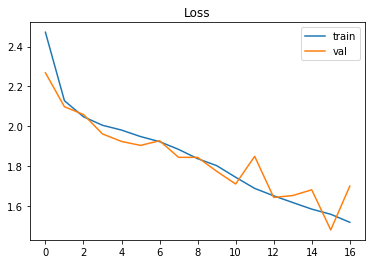

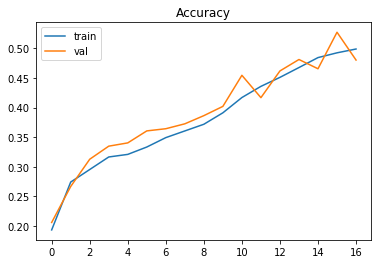

In [6]:
# model for saving
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=17, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
model_ft.apply(reset)
model_rs101_1, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=17)

In [9]:
# save model, loss, acc
torch.save(model_rs101_1, 'model_rs101_1')
with open('loss_log_model_rs101_1.pkl', 'wb') as file:
    pickle.dump(loss_log, file, pickle.HIGHEST_PROTOCOL)
with open('acc_log_model_rs101_1.pkl', 'wb') as file:
    pickle.dump(acc_log, file, pickle.HIGHEST_PROTOCOL)    

In [11]:
# load model, loss, acc
model_rs101_1 = torch.load('log/model_rs101_1')
with open('log/loss_log_model_rs101_1.pkl', 'rb') as file:
    loss_log_rs101_1 = pickle.load(file)
with open('log/acc_log_model_rs101_1.pkl', 'rb') as file:
    acc_log_rs101_1 = pickle.load(file)

Epoch 0/9
----------
train Loss: 1.6282 Acc: 0.4623
val Loss: 1.5802 Acc: 0.5143
lr:  0.01

Epoch 1/9
----------
train Loss: 1.5472 Acc: 0.4977
val Loss: 1.5579 Acc: 0.5189
lr:  0.01

Epoch 2/9
----------
train Loss: 1.5161 Acc: 0.4968
val Loss: 1.4457 Acc: 0.5354
lr:  0.01

Epoch 3/9
----------
train Loss: 1.4638 Acc: 0.5230
val Loss: 1.4353 Acc: 0.5483
lr:  0.01

Epoch 4/9
----------
train Loss: 1.4125 Acc: 0.5400
val Loss: 1.4494 Acc: 0.5520
lr:  0.01

Epoch 5/9
----------
train Loss: 1.3725 Acc: 0.5557
val Loss: 1.3472 Acc: 0.5805
lr:  0.01

Epoch 6/9
----------
train Loss: 1.3189 Acc: 0.5656
val Loss: 1.4135 Acc: 0.5621
lr:  0.01

Epoch 7/9
----------
train Loss: 1.2734 Acc: 0.5890
val Loss: 1.4826 Acc: 0.5547
lr:  0.01

Epoch 8/9
----------
train Loss: 1.2313 Acc: 0.5925
val Loss: 1.3197 Acc: 0.5842
lr:  0.01

Epoch 9/9
----------
train Loss: 1.1905 Acc: 0.6173
val Loss: 1.3579 Acc: 0.5741
lr:  0.01

Training complete in 14m 59s
Best val Acc: 0.584177, epoch 8


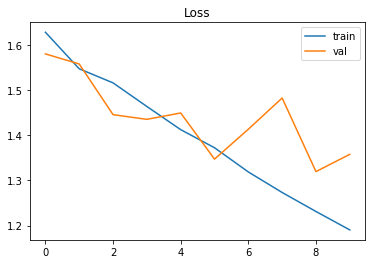

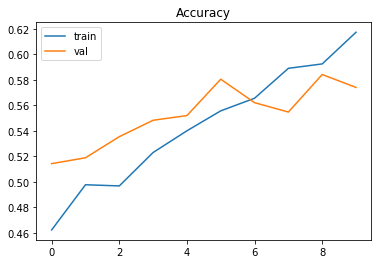

In [8]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_rs101_1.parameters(), lr=0.01)
model_rs101_2, loss_log2, acc_log2 = train_model(model_rs101_1, criterion, optimizer_ft, num_epochs=10)

Epoch 0/4
----------
train Loss: 1.6225 Acc: 0.4717
val Loss: 1.6642 Acc: 0.4876
lr:  0.01

Epoch 1/4
----------
train Loss: 1.5600 Acc: 0.4867
val Loss: 1.5057 Acc: 0.5382
lr:  0.01

Epoch 2/4
----------
train Loss: 1.5016 Acc: 0.5067
val Loss: 1.8558 Acc: 0.4609
lr:  0.01

Epoch 3/4
----------
train Loss: 1.4799 Acc: 0.5198
val Loss: 1.4684 Acc: 0.5529
lr:  0.01

Epoch 4/4
----------
train Loss: 1.4241 Acc: 0.5389
val Loss: 1.4129 Acc: 0.5704
lr:  0.01

Training complete in 7m 30s
Best val Acc: 0.570377, epoch 4


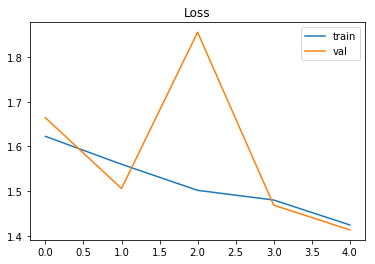

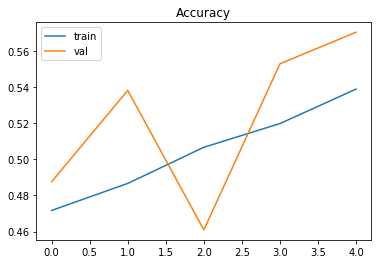

In [12]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_rs101_1.parameters(), lr=0.01)
#model_rs101_1.apply(reset)
model_rs101_2, loss_log2, acc_log2 = train_model(model_rs101_1, criterion, optimizer_ft, num_epochs=5)

In [13]:
# save model, loss, acc
torch.save(model_rs101_2, 'model_rs101_2')
with open('loss_log_model_rs101_2.pkl', 'wb') as file:
    pickle.dump(loss_log2, file, pickle.HIGHEST_PROTOCOL)
with open('acc_log_model_rs101_2.pkl', 'wb') as file:
    pickle.dump(acc_log2, file, pickle.HIGHEST_PROTOCOL)    

Epoch 0/4
----------
train Loss: 1.2800 Acc: 0.5805
val Loss: 1.2714 Acc: 0.5888
lr:  0.001

Epoch 1/4
----------
train Loss: 1.1931 Acc: 0.6107
val Loss: 1.2584 Acc: 0.5971
lr:  0.001

Epoch 2/4
----------
train Loss: 1.1626 Acc: 0.6208
val Loss: 1.2366 Acc: 0.6044
lr:  0.001

Epoch 3/4
----------
train Loss: 1.1225 Acc: 0.6295
val Loss: 1.2262 Acc: 0.6145
lr:  0.001

Epoch 4/4
----------
train Loss: 1.0682 Acc: 0.6463
val Loss: 1.2159 Acc: 0.6136
lr:  0.001

Training complete in 7m 28s
Best val Acc: 0.614535, epoch 3


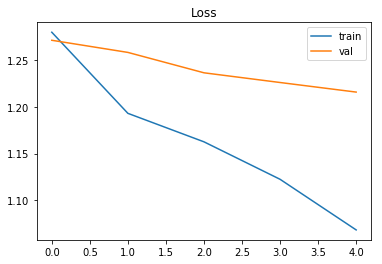

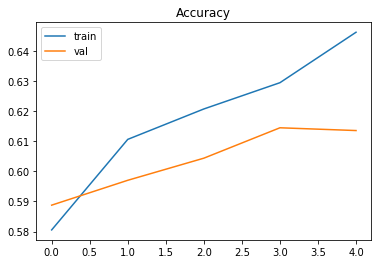

In [14]:
optimizer_ft = optim.Adam(model_rs101_2.parameters(), lr=0.001)
model_rs101_3, loss_log3, acc_log3 = train_model(model_rs101_2, criterion, optimizer_ft, num_epochs=5)

In [5]:
# load model, loss, acc
model_rs101_2 = torch.load('log/model_rs101_2')
with open('log/loss_log_model_rs101_2.pkl', 'rb') as file:
    loss_log_rs101_2 = pickle.load(file)
with open('log/acc_log_model_rs101_2.pkl', 'rb') as file:
    acc_log_rs101_2 = pickle.load(file)

Epoch 0/4
----------
train Loss: 1.3911 Acc: 0.5486
val Loss: 1.3298 Acc: 0.5695
lr:  0.001

Epoch 1/4
----------
train Loss: 1.3613 Acc: 0.5559
val Loss: 1.3199 Acc: 0.5796
lr:  0.001

Epoch 2/4
----------
train Loss: 1.3342 Acc: 0.5617
val Loss: 1.3111 Acc: 0.5787
lr:  0.001

Epoch 3/4
----------
train Loss: 1.3248 Acc: 0.5647
val Loss: 1.3065 Acc: 0.5777
lr:  0.001

Epoch 4/4
----------
train Loss: 1.3192 Acc: 0.5699
val Loss: 1.3031 Acc: 0.5796
lr:  0.001

Training complete in 7m 1s
Best val Acc: 0.579577, epoch 1


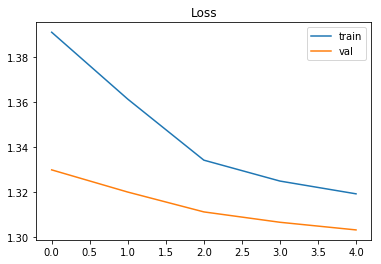

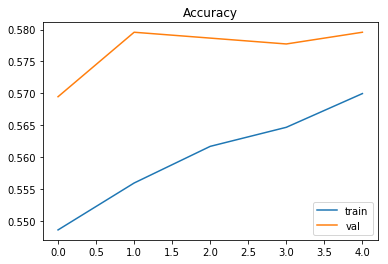

In [8]:
#optimizer_ft = optim.Adam(model_rs101_2.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_rs101_2.parameters(), lr=0.001, momentum=0.9)
model_rs101_3, loss_log3, acc_log3 = train_model(model_rs101_2, criterion, optimizer_ft, num_epochs=5)

In [9]:
# save model, loss, acc
torch.save(model_rs101_3, 'model_rs101_3')
with open('loss_log_model_rs101_3.pkl', 'wb') as file:
    pickle.dump(loss_log3, file, pickle.HIGHEST_PROTOCOL)
with open('acc_log_model_rs101_3.pkl', 'wb') as file:
    pickle.dump(acc_log3, file, pickle.HIGHEST_PROTOCOL)    

Epoch 0/9
----------
train Loss: 1.3359 Acc: 0.5642
val Loss: 1.3122 Acc: 0.5805
lr:  0.001

Epoch 1/9
----------
train Loss: 1.3198 Acc: 0.5630
val Loss: 1.3074 Acc: 0.5823
lr:  0.001

Epoch 2/9
----------
train Loss: 1.3193 Acc: 0.5686
val Loss: 1.3033 Acc: 0.5814
lr:  0.001

Epoch 3/9
----------
train Loss: 1.3077 Acc: 0.5720
val Loss: 1.3010 Acc: 0.5805
lr:  0.001

Epoch 4/9
----------
train Loss: 1.3065 Acc: 0.5764
val Loss: 1.2978 Acc: 0.5842
lr:  0.001

Epoch 5/9
----------
train Loss: 1.2952 Acc: 0.5750
val Loss: 1.2961 Acc: 0.5833
lr:  0.001

Epoch 6/9
----------
train Loss: 1.2892 Acc: 0.5826
val Loss: 1.2953 Acc: 0.5869
lr:  0.001

Epoch 7/9
----------
train Loss: 1.2836 Acc: 0.5805
val Loss: 1.2929 Acc: 0.5869
lr:  0.001

Epoch 8/9
----------
train Loss: 1.2854 Acc: 0.5787
val Loss: 1.2923 Acc: 0.5805
lr:  0.001

Epoch 9/9
----------
train Loss: 1.2863 Acc: 0.5801
val Loss: 1.2900 Acc: 0.5805
lr:  0.001

Training complete in 13m 57s
Best val Acc: 0.586937, epoch 6


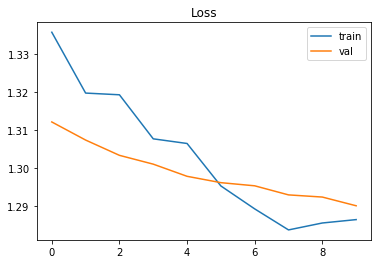

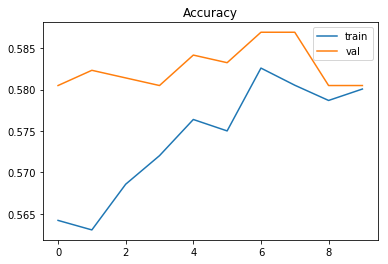

In [10]:
optimizer_ft = optim.SGD(model_rs101_3.parameters(), lr=0.001, momentum=0.9)
model_rs101_4, loss_log4, acc_log4 = train_model(model_rs101_3, criterion, optimizer_ft, num_epochs=10)

In [16]:
# load model
model_rs101_2 = torch.load('log/model_rs101_2')

Epoch 0/9
----------
train Loss: 1.2833 Acc: 0.5798
val Loss: 1.2706 Acc: 0.5961
lr:  0.001

Epoch 1/9
----------
train Loss: 1.1946 Acc: 0.6077
val Loss: 1.2463 Acc: 0.6072
lr:  0.001

Epoch 2/9
----------
train Loss: 1.1540 Acc: 0.6263
val Loss: 1.2384 Acc: 0.6017
lr:  0.001

Epoch 3/9
----------
train Loss: 1.1157 Acc: 0.6392
val Loss: 1.2194 Acc: 0.6035
lr:  0.001

Epoch 4/9
----------
train Loss: 1.0766 Acc: 0.6489
val Loss: 1.2219 Acc: 0.6081
lr:  0.001

Epoch 5/9
----------
train Loss: 1.0309 Acc: 0.6608
val Loss: 1.2087 Acc: 0.6210
lr:  0.001

Epoch 6/9
----------
train Loss: 0.9884 Acc: 0.6776
val Loss: 1.2071 Acc: 0.6274
lr:  0.001

Epoch 7/9
----------
train Loss: 0.9332 Acc: 0.7006
val Loss: 1.2044 Acc: 0.6228
lr:  0.001

Epoch 8/9
----------
train Loss: 0.8832 Acc: 0.7147
val Loss: 1.2164 Acc: 0.6155
lr:  0.001

Epoch 9/9
----------
train Loss: 0.8444 Acc: 0.7246
val Loss: 1.2349 Acc: 0.6201
lr:  0.001

Training complete in 14m 53s
Best val Acc: 0.627415, epoch 6


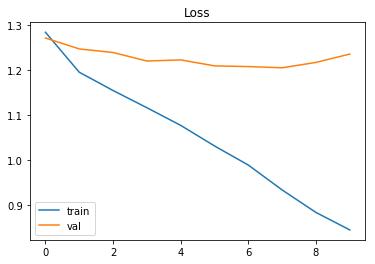

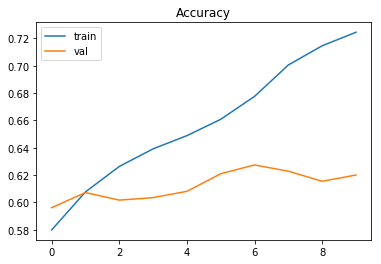

In [12]:
optimizer_ft = optim.Adam(model_rs101_2.parameters(), lr=0.001)
model_rs101_3, loss_log3, acc_log3 = train_model(model_rs101_2, criterion, optimizer_ft, num_epochs=10)

In [17]:
optimizer_ft = optim.SGD(model_rs101_2.parameters(), lr=0.01, momentum=0.9)
model_rs101_3, loss_log3, acc_log3 = train_model(model_rs101_2, criterion, optimizer_ft, num_epochs=10)

Epoch 0/119
----------
train Loss: 1.3901 Acc: 0.5488
val Loss: 1.3297 Acc: 0.5741
lr:  0.001

Epoch 1/119
----------
train Loss: 1.3480 Acc: 0.5573
val Loss: 1.3175 Acc: 0.5768
lr:  0.001

Epoch 2/119
----------
train Loss: 1.3340 Acc: 0.5619
val Loss: 1.3108 Acc: 0.5787
lr:  0.001

Epoch 3/119
----------
train Loss: 1.3225 Acc: 0.5720
val Loss: 1.3074 Acc: 0.5814
lr:  0.001

Epoch 4/119
----------
train Loss: 1.3195 Acc: 0.5633
val Loss: 1.3029 Acc: 0.5777
lr:  0.001

Epoch 5/119
----------
train Loss: 1.3063 Acc: 0.5704
val Loss: 1.3006 Acc: 0.5814
lr:  0.001

Epoch 6/119
----------
train Loss: 1.3013 Acc: 0.5789
val Loss: 1.2981 Acc: 0.5842
lr:  0.001

Epoch 7/119
----------
train Loss: 1.2939 Acc: 0.5778
val Loss: 1.2958 Acc: 0.5869
lr:  0.001

Epoch 8/119
----------
train Loss: 1.2925 Acc: 0.5743
val Loss: 1.2944 Acc: 0.5833
lr:  0.001

Epoch 9/119
----------
train Loss: 1.2871 Acc: 0.5817
val Loss: 1.2935 Acc: 0.5823
lr:  0.001

Epoch 10/119
----------
train Loss: 1.2870 Acc: 0.

KeyboardInterrupt: 

In [5]:
model_ft = models.resnet101(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/39
----------
train Loss: 2.4582 Acc: 0.2032
val Loss: 2.3116 Acc: 0.2511
lr:  0.01

Epoch 1/39
----------
train Loss: 2.1643 Acc: 0.2589
val Loss: 2.4608 Acc: 0.2217
lr:  0.01

Epoch 2/39
----------
train Loss: 2.1344 Acc: 0.2715
val Loss: 2.1726 Acc: 0.2557
lr:  0.01

Epoch 3/39
----------
train Loss: 2.1001 Acc: 0.2750
val Loss: 2.1434 Acc: 0.2659
lr:  0.01

Epoch 4/39
----------
train Loss: 2.0530 Acc: 0.2816
val Loss: 3.3376 Acc: 0.2475
lr:  0.01

Epoch 5/39
----------
train Loss: 2.0080 Acc: 0.3067
val Loss: 2.0981 Acc: 0.2879
lr:  0.01

Epoch 6/39
----------
train Loss: 1.9521 Acc: 0.3247
val Loss: 2.1067 Acc: 0.3054
lr:  0.01

Epoch 7/39
----------
train Loss: 1.9024 Acc: 0.3705
val Loss: 4.0977 Acc: 0.2346
lr:  0.01

Epoch 8/39
----------
train Loss: 1.8453 Acc: 0.3815
val Loss: 1.7680 Acc: 0.4066
lr:  0.01

Epoch 9/39
----------
train Loss: 1.7875 Acc: 0.4192
val Loss: 1.7459 Acc: 0.4379
lr:  0.01

Epoch 10/39
----------
train Loss: 1.7151 Acc: 0.4429
val Loss: 1.5797

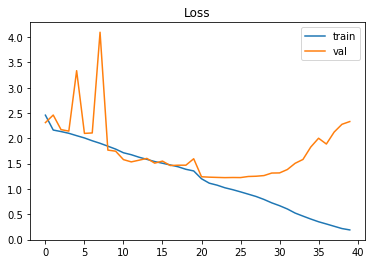

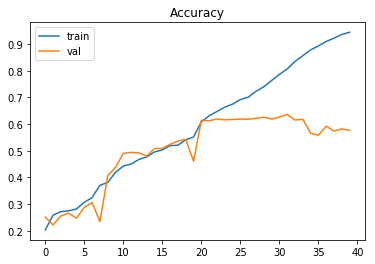

In [6]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=False
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

In [5]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/34
----------
train Loss: 2.9853 Acc: 0.1422
val Loss: 2.8740 Acc: 0.1564
lr:  0.1

Epoch 1/34
----------
train Loss: 2.3948 Acc: 0.1505
val Loss: 2.4951 Acc: 0.1858
lr:  0.1

Epoch 2/34
----------
train Loss: 2.3275 Acc: 0.2050
val Loss: 2.2146 Acc: 0.2236
lr:  0.1

Epoch 3/34
----------
train Loss: 2.2409 Acc: 0.2333
val Loss: 2.2479 Acc: 0.2300
lr:  0.1

Epoch 4/34
----------
train Loss: 2.1991 Acc: 0.2499
val Loss: 2.2189 Acc: 0.2236
lr:  0.1

Epoch 5/34
----------
train Loss: 2.1704 Acc: 0.2561
val Loss: 2.1893 Acc: 0.2217
lr:  0.1

Epoch 6/34
----------
train Loss: 2.1363 Acc: 0.2621
val Loss: 2.1960 Acc: 0.2282
lr:  0.1

Epoch 7/34
----------
train Loss: 2.1398 Acc: 0.2614
val Loss: 2.1507 Acc: 0.2226
lr:  0.1

Epoch 8/34
----------
train Loss: 2.1440 Acc: 0.2554
val Loss: 2.1761 Acc: 0.2309
lr:  0.1

Epoch 9/34
----------
train Loss: 2.1486 Acc: 0.2605
val Loss: 2.2132 Acc: 0.2254
lr:  0.1

Epoch 10/34
----------
train Loss: 2.0980 Acc: 0.2727
val Loss: 2.0688 Acc: 0.28

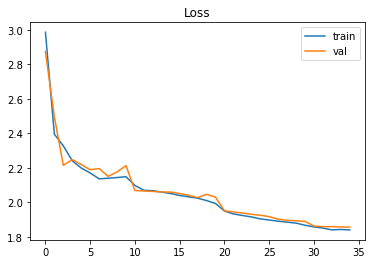

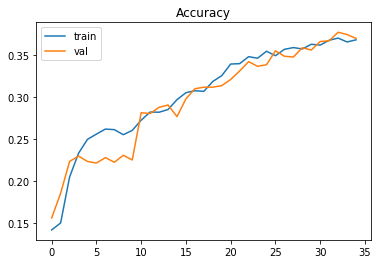

In [7]:
# resnet152, batch_size=16, Adam, step_size=20, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs152 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=35)